2024-04-18 19:52:56.053590: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 19:52:56.056731: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 19:52:56.100172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 19:52:56.937675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Ejecutando tarea 1.0 con Potencia 0.9 y Duracion 5.0 con SoC actual: 90.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Ejecutando tarea 3.0 con Potencia 1.0 y Duracion 5.0 con SoC actual: 85.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Ejecutando tarea 4.0 con Potencia 2.5 y Duracion 1.0 con SoC actual: 83.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Ejecutando tarea 2.0 con Potencia 20.0 y Duracion 1.0 con SoC actual: 63.0


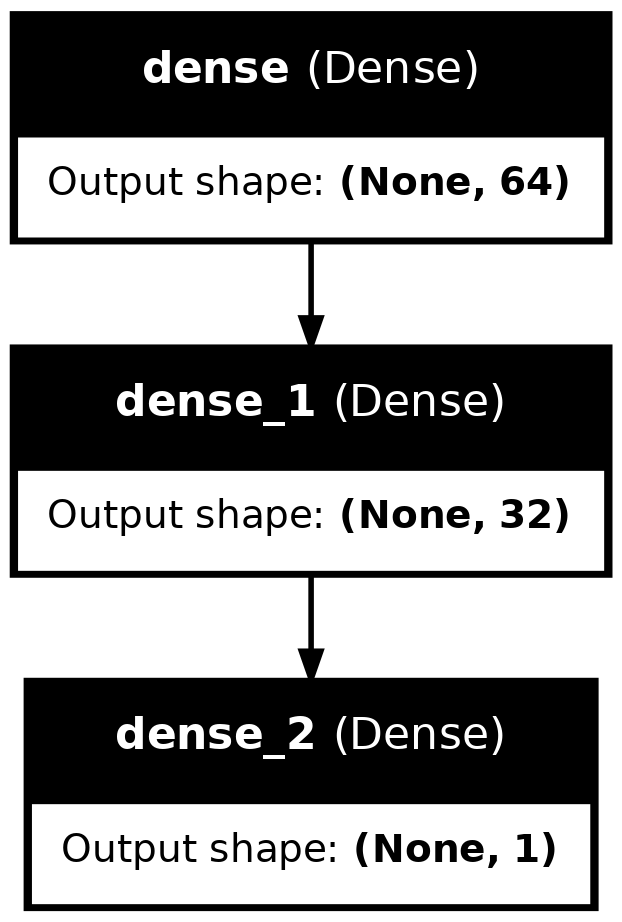

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Input
import tensorflow as tf

def construirModelo(n_entradas):
    """
    Construye y compila un modelo secuencial de red neuronal.

    Args:
    n_entradas (int): Número total de variables de entrada para el modelo.

    Returns:
    Un modelo de Keras compilado listo para entrenarse.
    """
    modelo = Sequential([
        Input(shape=(n_entradas,)),  # Capa de entrada ajustada al número de entradas
        Dense(64, activation='relu'),  # Primera capa oculta
        Dense(32, activation='relu'),  # Segunda capa oculta
        Dense(1, activation='sigmoid')  # Capa de salida
    ])
    modelo.compile(optimizer='adam', loss='binary_crossentropy')
    return modelo

def generarDatosSinteticos(numMuestras=1000, SocInicial=95):
    np.random.seed(42)  # Para reproducibilidad
    HorasInicio = np.random.uniform(0, 100, numMuestras)
    Duraciones = np.random.uniform(1, 10, numMuestras)
    Potencias = np.random.uniform(1, 3, numMuestras)
    PriorityTs = np.random.uniform(0, 1, numMuestras)
    PriorityEs = np.random.uniform(0, 1, numMuestras)

    dfEntrenamiento = pd.DataFrame({
        'HoraInicio': HorasInicio,
        'Duracion': Duraciones,
        'Potencia': Potencias,
        'PriorityT': PriorityTs,
        'PriorityE': PriorityEs
    })

    # Factor de decisión basado en Potencia y Prioridades
    dfEntrenamiento['FactorDecision'] = (1 / dfEntrenamiento['Potencia']) * (dfEntrenamiento['PriorityT'] + dfEntrenamiento['PriorityE'])
    # Normalizar el factor de decisión y establecer un umbral para decidir la ejecución
    factor_maximo = dfEntrenamiento['FactorDecision'].max()
    dfEntrenamiento['Ejecutar'] = np.where(dfEntrenamiento['FactorDecision'] > factor_maximo * 0.5, 1, 0)

    return dfEntrenamiento.drop('FactorDecision', axis=1)  # Retornar el DataFrame sin la columna de FactorDecision

def entrenarModelo(modelo, dfEntrenamiento):
    """
    Entrena el modelo de red neuronal con los datos de entrenamiento proporcionados.

    Args:
    modelo: Modelo de Keras a entrenar.
    dfEntrenamiento: DataFrame de pandas con los datos de entrenamiento.
    """
    caracteristicas = dfEntrenamiento.drop('Ejecutar', axis=1).values
    objetivos = dfEntrenamiento['Ejecutar'].values
    modelo.fit(caracteristicas, objetivos, epochs=50, batch_size=32, verbose=0)

def ejecutarTareaSeleccionada(dfTareas, SoC_actual, modelo):
    if len(dfTareas) == 0:
        return None, SoC_actual, dfTareas

    caracteristicasTareas = dfTareas[['HoraInicio', 'Duracion', 'Potencia', 'PriorityT', 'PriorityE']].values
    decisiones = modelo.predict(caracteristicasTareas).flatten()

    # Ajustar las decisiones basándose en la Potencia
    decisiones_ajustadas = decisiones / dfTareas['Potencia']

    indiceSeleccionado = np.argmax(decisiones_ajustadas)
    tareaSeleccionada = dfTareas.iloc[indiceSeleccionado]

    nuevo_SoC = SoC_actual - tareaSeleccionada['Potencia'] * tareaSeleccionada['Duracion']
    nuevo_SoC = max(nuevo_SoC, 0)  # Asegurarse de que el SoC no sea negativo

    dfTareas = dfTareas.drop(dfTareas.index[indiceSeleccionado])

    return tareaSeleccionada, nuevo_SoC, dfTareas

# Definir parámetros iniciales
SocInicial = 95  # Estado de carga inicial

# Generar datos sintéticos para entrenamiento
dfEntrenamiento = generarDatosSinteticos(numMuestras=1000, SocInicial=SocInicial)

# Determinar el número total de entradas para el modelo
n_entradas = dfEntrenamiento.shape[1] - 1  # Restar 1 para excluir la columna objetivo 'Ejecutar'

# Crear y entrenar el modelo
modelo = construirModelo(n_entradas)
entrenarModelo(modelo, dfEntrenamiento)

# Crear un DataFrame de tareas de ejemplo
dfTareas = pd.DataFrame({
    'ID': [1, 2, 3, 4],
    'HoraInicio': [10, 30, 50, 70],
    'Duracion': [5, 1, 5, 1],
    'Potencia': [0.9, 20, 1, 2.5],
    'PriorityT': [0.2, 1, 0.4, 0.3],
    'PriorityE': [0.2, 1, 0.1, 0.9]
})

# Simular la ejecución de tareas y la gestión del SoC
SoC_actual = SocInicial
while len(dfTareas) > 0:
    tareaSeleccionada, SoC_actual, dfTareas = ejecutarTareaSeleccionada(dfTareas, SoC_actual, modelo)
    if tareaSeleccionada is not None:
        print(f"Ejecutando tarea {tareaSeleccionada['ID']} con Potencia {tareaSeleccionada['Potencia']} y Duracion {tareaSeleccionada['Duracion']} con SoC actual: {SoC_actual}")
    else:
        print("No hay tareas aptas para ejecutar.")
        break
tf.keras.utils.plot_model(modelo, to_file='modelo.png', show_shapes=True, show_layer_names=True)
